### Fixing decoder

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

from model import GrammarVAE
from util import Timer, AnnealKL, load_data

In [2]:
# Init model, dont train it and generate some equations
ENCODER_HIDDEN = 20
Z_SIZE = 2
DECODER_HIDDEN = 20
RNN_TYPE = 'lstm'
BATCH_SIZE = 32
MAX_LENGTH = 15
OUTPUT_SIZE = 12
LR = 1e-2
CLIP = 5.
PRINT_EVERY = 100
EPOCHS = 3

model = GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE, RNN_TYPE)

Using device: mps


In [9]:
batch_size = 2
x = torch.randn(batch_size, OUTPUT_SIZE, MAX_LENGTH)  # OUTPUT_SIZE: number of rules (for 1-hot encoding)
mu, sigma = model.encoder(x)
print(mu, sigma)  # z

logits = model.decoder(mu, 15)
print(logits.shape)

tensor([[ 0.1680, -0.2196],
        [ 0.1450, -0.2121]], grad_fn=<AddmmBackward0>) tensor([[0.7805, 0.7860],
        [0.8027, 0.7900]], grad_fn=<SoftplusBackward0>)
torch.Size([2, 15, 12])


In [126]:
# torch.manual_seed(0)

import model as m
from importlib import reload
import util
from grammar import GCFG
reload(m)

# Init model, dont train it and generate some equations
ENCODER_HIDDEN = 20
Z_SIZE = 2
DECODER_HIDDEN = 20
RNN_TYPE = 'lstm'
BATCH_SIZE = 32
MAX_LENGTH = 15
OUTPUT_SIZE = len(GCFG.productions()) + 1  # 1-hot + numerical
LR = 1e-2
CLIP = 5.
PRINT_EVERY = 100
EPOCHS = 3

model = m.GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE, RNN_TYPE)  # .to(device='mps')

batch_size = 1
x = torch.randn(batch_size, OUTPUT_SIZE, MAX_LENGTH).to(model.device) * 10  # OUTPUT_SIZE: number of rules (for 1-hot encoding)
mu, sigma = model.encoder(x)
print(f'{mu = }')

rules = model.generate(mu, sample=False, max_length=15)
print(rules)

if len(rules) < 15:
    tree = util.make_nltk_tree(rules)
    print(tree)
else:
    print('Invalid. Too many rules.')

mu = tensor([[-0.1692,  0.0015]], grad_fn=<AddmmBackward0>)
[S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T, S -> S '+' T]
Invalid. Too many rules.


In [89]:
tree.pprint()

(S (T 3))


### MPS?

In [124]:
next(model.parameters()).is_mps

True

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Data loading/parsing

In [144]:
data_path = '../data/equation2_15_dataset_parsed.h5'
data = load_data(data_path)
# Turn it into a float32 PyTorch Tensor
data = torch.from_numpy(data).float()

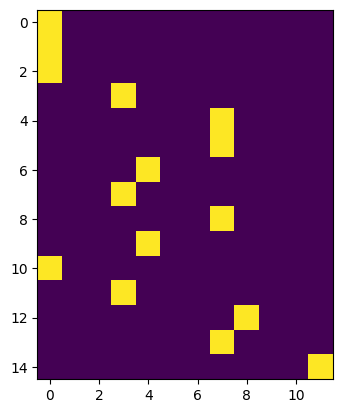

array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.]],

       ...,

       [[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [111]:
from matplotlib import pyplot as plt

plt.imshow(one_hot[4, ...])
plt.show()

one_hot

### Using trained model

In [6]:
import os
import torch
import sympy as sp
from torch.autograd import Variable

from model import GrammarVAE
from stack import Stack

from util import load_data, prods_to_eq
from train import ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE

torch.manual_seed(10)

# Load saved model
model_path = os.path.abspath('../checkpoints/model5epoch.pt')
model = torch.load(model_path)
# model = GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE)

# Load data
data_path = os.path.abspath('../data/equation2_15_dataset_parsed.h5')
data = load_data(data_path)

# Load raw equation strings
data_path = os.path.abspath('../data/equation2_15_dataset.txt')
with open(data_path, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]

def data2input(x):
    x = torch.from_numpy(x).float().unsqueeze(0).transpose(-2, -1)
    return Variable(x)

def predict(x):
    x = data2input(x)
    logits = model(x)
    _, y = logits.squeeze(0).max(-1)
    return y

def evaluate(y, y_):
    try:
        (y == y_).mean()
    except:
        y_ = y_.data.numpy()
    return (y == y_).mean()


#### encode-decode single equation from equation file

In [16]:
from matplotlib import pyplot as plt
from grammar import GCFG

def plot_onehot(onehot_matrix, grammar):
    plt.imshow(onehot_matrix)

    plt.ylabel('Sequence')
    plt.xlabel('Rule')
    xticks = grammar.productions()
    plt.xticks(range(len(xticks)), xticks, rotation='vertical')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [30]:
# model = GrammarVAE(ENCODER_HIDDEN, Z_SIZE, DECODER_HIDDEN, OUTPUT_SIZE, rnn_type='lstm', device='cpu')
model_path = os.path.abspath('../checkpoints/model5epoch.pt')
model = torch.load(model_path)

eq = 'x + x + ( 1 ) + exp( 1 / x )'
expr = 2*x + exp(1/x) + 1


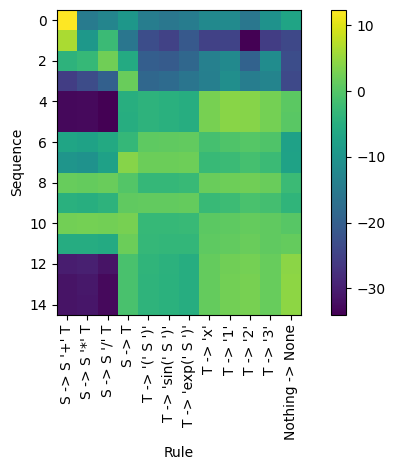

In [31]:
i = 300

eq = eqs[i]
print(f'{eq = }')
expr = sp.simplify(sp.sympify(eq))
print(f'{expr = }')

x = data2input(data[i])
mu, sigma = model.encoder(x)

logits = model.decoder(mu, max_length=15)
plot_onehot(logits[0, ...].detach().numpy(), GCFG)

In [7]:
i = 1

eq = eqs[i]
print(f'{eq = }')
expr = sp.simplify(sp.sympify(eq))
print(f'{expr = }')

x = data2input(data[i])
mu, sigma = model.encoder(x)
production = model.generate(mu, sample=True, max_length=15)

print(f'{production = }')
eq_hat = prods_to_eq(production, verbose=True)
if eq_hat:
    expr_hat = sp.simplify(sp.sympify(eq_hat))
    print(f'{expr_hat = }')



eq = 'x + x + ( x ) + ( x + 1 )'
expr = 4*x + 1
production = [S -> S '+' T, S -> S '+' T, S -> S '/' T, S -> T, T -> '3', T -> '1', T -> '(' S ')', S -> T, T -> '2', T -> 'sin(' S ')', S -> S '/' T, S -> T, T -> '2', T -> '1']
expr_hat = sin(2) + 5


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [225]:

for i in range(0, len(eqs), 1000):
    eq = eqs[i]
    expr = sp.simplify(sp.sympify(eq))

    x = data2input(data[i])
    mu, sigma = model.encoder(x)
    production = model.generate(mu, sample=True, max_length=15)

    eq_hat = prods_to_eq(production)
    if eq_hat:
        expr_hat = sp.simplify(sp.sympify(eq_hat))

    print(f'{expr = }  ///////  {expr_hat = }')

expr = 5*x  ///////  expr_hat = exp(2*x) + 1/2 + E
expr = 2*x + sin(2) + 2/x  ///////  expr_hat = sin(x) + sin(2) + 3
expr = 3*x + sin(3*x)  ///////  expr_hat = sin(4) + sin(3) + 1
expr = x + exp(x**2) + 3  ///////  expr_hat = exp(2*x) + sin(3) + 2/3
expr = 3*x + 1 + E  ///////  expr_hat = sin(1) + exp(2) + 1/x
expr = x + 4 + 2/x  ///////  expr_hat = sin(2) + 3
expr = x + sin(3*x) + sin(1) + 2  ///////  expr_hat = x + 4
expr = x + exp(x**2) + 2 + exp(3)  ///////  expr_hat = x + 1 + exp(2)
expr = 3*x + 5  ///////  expr_hat = 8/3 + exp(5)
expr = x + exp(x) + 3 + 2/x  ///////  expr_hat = x + sin(4) + 2
expr = x + sin(3*x) + 5  ///////  expr_hat = sin(x) + sin(2) + 2
expr = x + exp(x**2) + sin(x) + 1  ///////  expr_hat = 5 + exp(2)
expr = 3*x + 1 + exp(3)  ///////  expr_hat = sin(3) + 4
expr = 3 + 2/x  ///////  expr_hat = sin(2) + 6
expr = sin(3*x) + sin(3) + 2  ///////  expr_hat = sin(2) + 1 + exp(2)
expr = exp(x**2) + 3  ///////  expr_hat = sin(4) + sin(1) + 2
expr = 2*x + sin(x) + 3  //